Mean Absolute Error (MAE): 8.5388
R² Score: 0.5521


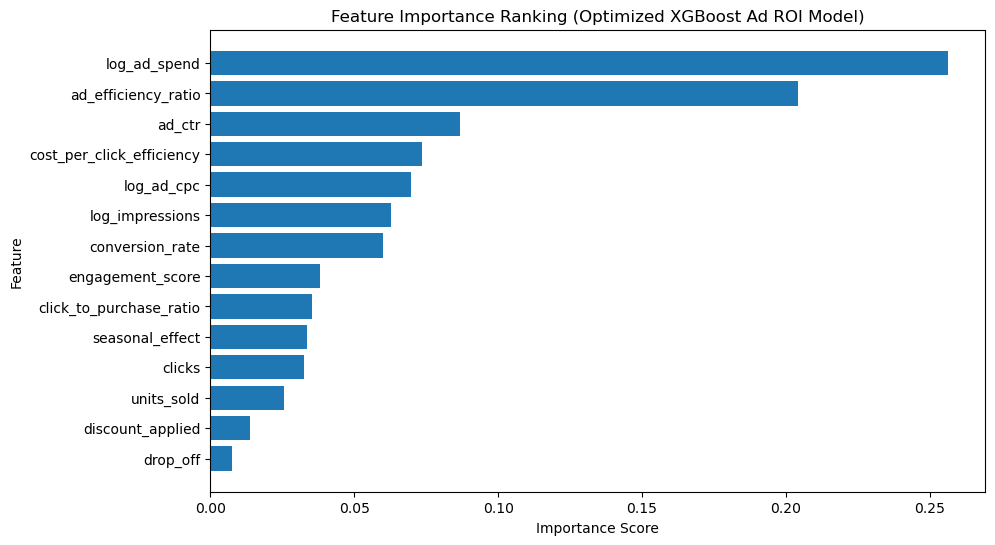


Top 10 Important Features Influencing Ad ROI:
                      Feature  Importance
5                log_ad_spend    0.256376
8         ad_efficiency_ratio    0.204302
1                      ad_ctr    0.086742
9   cost_per_click_efficiency    0.073509
6                  log_ad_cpc    0.069615
7             log_impressions    0.062876
3             conversion_rate    0.060114
10           engagement_score    0.038247
2     click_to_purchase_ratio    0.035290
11            seasonal_effect    0.033643


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# Load Dataset
file_path = "click_behavior_analysis_with_drop_off.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Compute ROAS (Return on Ad Spend)
df['roas'] = np.where(df['ad_spend'] > 0, df['revenue'] / df['ad_spend'], 0)

# Log Transformations for skewed features
df['log_ad_spend'] = np.log1p(df['ad_spend'])
df['log_impressions'] = np.log1p(df['impressions'])
df['log_ad_cpc'] = np.log1p(df['ad_cpc'])

# Feature Interactions (handling division by zero)
df['ad_efficiency_ratio'] = df['ad_spend'] / (df['impressions'] + 1)  # Avoid div by zero
df['cost_per_click_efficiency'] = df['ad_cpc'] / (df['conversion_rate'] + 1e-9)  # Avoid div by zero
df['engagement_score'] = df['click_to_purchase_ratio'] * df['click_intensity'].astype('category').cat.codes
df['seasonal_effect'] = df['month'].astype('category').cat.codes * df['conversion_rate']

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values only for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Define features
features = [
    'clicks', 'ad_ctr', 'click_to_purchase_ratio', 'conversion_rate', 'drop_off',
    'log_ad_spend', 'log_ad_cpc', 'log_impressions', 'ad_efficiency_ratio',
    'cost_per_click_efficiency', 'engagement_score', 'seasonal_effect',
    'discount_applied', 'units_sold'
]

# One-Hot Encoding for categorical features
categorical_features = ['day_of_week', 'month', 'click_intensity', 'click_efficiency']
df = pd.get_dummies(df, columns=categorical_features)

# Extract feature matrix (X) and target variable (y)
X = df[features]
y = df['roas']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=10, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

# Best model from hyperparameter tuning
best_xgb = random_search.best_estimator_

# Predictions
y_pred = best_xgb.predict(X_test_scaled)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature Importance Ranking
feature_importance = best_xgb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Ranking (Optimized XGBoost Ad ROI Model)')
plt.gca().invert_yaxis()
plt.show()

# Print Top 10 Important Features
print("\nTop 10 Important Features Influencing Ad ROI:")
print(feature_importance_df.head(10))

